# Group Analysis: FOOOFed EEG Analysis: Rest

Apply FOOOF to resting state EEG data, and compare results between YNG and OLD groups.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload

In [2]:
from os import listdir
from os.path import join as pjoin

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, pearsonr

from fooof import FOOOFGroup
from fooof.analysis import get_band_peak_group
from fooof.core.funcs import expo_nk_function

In [3]:
# Import custom code for this analysis
import sys
sys.path.append('../code')

%autoreload 2
from plts import *
from utils import *
from analysis import *

# Settings

In [4]:
# Set path to load results from
res_path = '/Users/tom/Documents/Research/1-Projects/1-Current/fooof/2-Data/Results/'

# Set whether to drop outlier subjects, in terms of FOOOF Goodness-of-Fit metrics
drop_outliers = True

# Set indices to separate groups
from settings import YNG_INDS, OLD_INDS

# Set average function to use
avg_func = np.nanmean
#avg_func = np.nanmedian

# Wether to save out plots or not
save_fig = False

print('Number of young subjects:  ', len(YNG_INDS))
print('Number of  old  subjects:  ', len(OLD_INDS))

Number of young subjects:   17
Number of  old  subjects:   14


### Load FOOOF Data

In [5]:
# Set the data folder to run
dat_folder = 'FOOOF-AllCh'

In [6]:
# Get files
files = listdir(pjoin(res_path, dat_folder))
files = [file for file in files if 'RAW' in file]
files.sort()

In [7]:
# Load all subject FOOOFGroups
fg = FOOOFGroup()
fgs = []
for file in files:
    fg.load(file, pjoin(res_path, dat_folder))
    fgs.append(fg.copy())

### Extract FOOOF Data

In [8]:
# Grab alphas from each subject
ch_ind = 28  # 28 is Oz
alphas = np.empty(shape=[len(fgs), 3])
for ind, fg in enumerate(fgs):
    #alphas[ind, :] = get_band_peak_group(fg.get_params('gaussian_params'), [7, 14], len(fg))[ch_ind, :]
    alphas[ind, :] = get_band_peak_group(fg.get_params('peak_params'), [7, 14], len(fg))[ch_ind, :]

In [9]:
# Grab aperiodic params from each subject
ch_ind = 47 # 47 is Cz
aps = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    aps[ind, :] = fg.get_params('aperiodic_params')[ch_ind]
offs = aps[:, 0]
exps = aps[:, 1]

In [10]:
# Extract error & R^2 from FOOOF fits
ch_ind = 28  # Oz

errs = []; r2s = []

for fg in fgs:
    errs.append(fg.get_results()[ch_ind].error)
    r2s.append(fg.get_results()[ch_ind].r_squared)

errs = np.array(errs)
r2s = np.array(r2s)

### Check For Outliers

This check and drop procedure finds & drops subjects for which the FOOOF goodness-of-fit metrics are statistical outliers, indicating poor fits. 

In [11]:
# Settings for outlier check
std_thresh = 2.5

In [12]:
# Check for outliers using FOOOF Goodness of Fit metrics
err_outliers = check_outliers(errs, std_thresh)
std_outliers = check_outliers(r2s, std_thresh)

In [13]:
# Check if the same outliers are detected for each GoF measure
print(err_outliers)
print(std_outliers)

[21]
[21]


In [14]:
# Combine outlier list across GoF metrics
bad_inds = set(err_outliers + std_outliers)

In [15]:
# Drop outlier GoF values
if drop_outliers:
    print('DROPPING {} OUTLIER'.format(len(bad_inds)))
    for bad_ind in bad_inds:
        print('\tRemoving index # ', bad_ind)
        try:
            YNG_INDS.remove(bad_ind)
            OLD_INDS.remove(bad_ind)
        except: pass

DROPPING 1 OUTLIER
	Removing index #  21


### Dataset Checks

In [16]:
print('Total Number of analyzed subjects: \t{}'.format(len(YNG_INDS)+len(OLD_INDS)))
print('Degrees of Freedom for Group Tests: \t{}'.format(len(YNG_INDS)+len(OLD_INDS)-2))

Total Number of analyzed subjects: 	30
Degrees of Freedom for Group Tests: 	28


## Aperiodic Comparisons

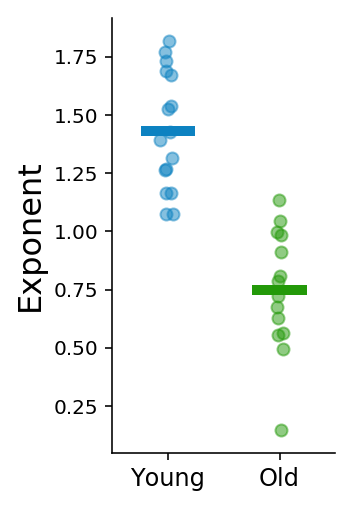

In [17]:
# Plot exponent comparison
plot_comp_scatter(exps, 'Exponent', save_fig=save_fig, save_name='exponents')

In [18]:
# Statistically test exponent difference
print_stat('Exponent t-test', *ttest_ind(exps[YNG_INDS], exps[OLD_INDS]))
print_stat('YNG / OLD Means', np.mean(exps[YNG_INDS]), np.mean(exps[OLD_INDS]))
print_stat('Abs / Std Diff', mean_diff(exps[YNG_INDS], exps[OLD_INDS]), cohens_d(exps[YNG_INDS], exps[OLD_INDS]))

Exponent t-test: 	  7.2386 	 0.0000
YNG / OLD Means: 	  1.4304 	 0.7461
Abs / Std Diff: 	  0.6844 	 2.6456


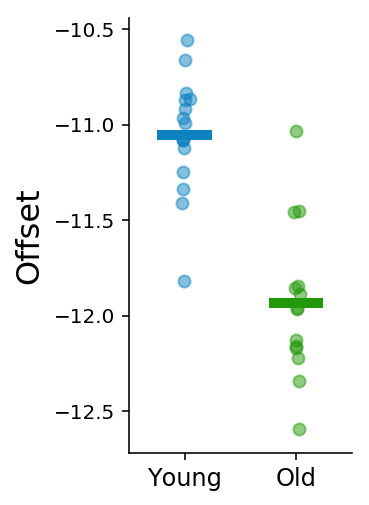

In [19]:
# Plot offset comparison
plot_comp_scatter(offs, 'Offset', save_fig=save_fig, save_name='Offsets')

In [20]:
# Statistically test offset difference
print_stat('Offset t-test ', *ttest_ind(offs[YNG_INDS], offs[OLD_INDS]))
print_stat('YNG / OLD Means', np.mean(offs[YNG_INDS]), np.mean(offs[OLD_INDS]))
print_stat('Abs / Std Diff', mean_diff(offs[YNG_INDS], offs[OLD_INDS]), cohens_d(offs[YNG_INDS], offs[OLD_INDS]))

Offset t-test : 	  6.8150 	 0.0000
YNG / OLD Means: 	 -11.0517 	-11.9337
Abs / Std Diff: 	  0.8820 	 2.4693


## Periodic Comparisons

### Check total alpha power

'Total alpha power', from the FOOOF model, is the model results of the aperiodic + the alpha peak amplitude.

In [21]:
# Set the channel to extract alpha power from
ch_ind = 28 # Oz

# Collect the aperiodic parameters for each subject
oz_aps = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    oz_aps[ind, :] = fg.get_params('aperiodic_params')[ch_ind]

# Calculate total alpha as the value of the BG function at alpha CF, please the amplitude of the alpha peak
tot_alphas = []
for bg, cf, amp in zip(oz_aps, alphas[:, 0], alphas[:, 1]):

    # If there is no alpha, get the aperiodic component at CF of 10, and set alpha amplitude to zero
    if np.isnan(cf):
        cf, amp = 10, 0
    
    # Calculate the value of the aperiodic function at the alpha-CF, and add the alpha-amp
    tot_alphas.append(expo_nk_function(np.array([cf]), *bg)[0] + amp)
    
tot_alphas = np.array(tot_alphas)

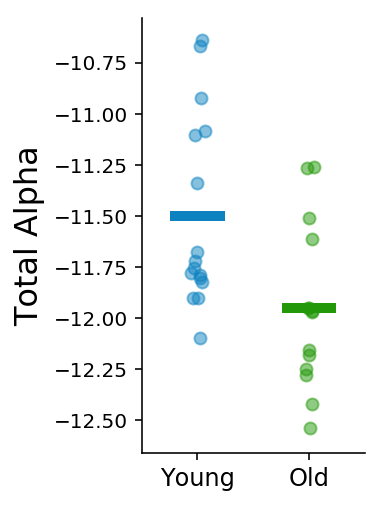

In [22]:
# Plot total alpha - total power values from the FOOOF model at individualzed alpha CFs
#  Note: this is equivalent to doing an individualed alpha frequency analysis, comparing total power
plot_comp_scatter(tot_alphas, 'Total Alpha', save_fig=save_fig, save_name='TotalAlpha')

In [23]:
print_stat('Total Alpha t-test', *ttest_ind(tot_alphas[YNG_INDS], tot_alphas[OLD_INDS]))
print_stat('YNG / OLD Means', np.mean(tot_alphas[YNG_INDS]), np.mean(tot_alphas[OLD_INDS]))
print_stat('Abs / Std Diff', mean_diff(tot_alphas[YNG_INDS], tot_alphas[OLD_INDS]),
                             cohens_d(tot_alphas[YNG_INDS], tot_alphas[OLD_INDS]))

Total Alpha t-test: 	  2.8001 	 0.0092
YNG / OLD Means: 	 -11.5005 	-11.9515
Abs / Std Diff: 	  0.4510 	 1.0302


### Check number of extracted oscillations

In [24]:
ch_ind = 28  # Oz
n_oscs = []
for fg in fgs:
    n_oscs.append(fg.get_results()[ch_ind].peak_params.shape[0])
n_oscs = np.array(n_oscs)

In [25]:
print_stat('Number Oscs Diff', *ttest_ind(n_oscs[YNG_INDS], n_oscs[OLD_INDS]))
print_stat('YNG / OLD Means', np.mean(n_oscs[YNG_INDS]), np.mean(n_oscs[OLD_INDS]))
print_stat('Abs / Std Diff', mean_diff(n_oscs[YNG_INDS], n_oscs[OLD_INDS]),
                             cohens_d(n_oscs[YNG_INDS], n_oscs[OLD_INDS]))

Number Oscs Diff: 	 -0.2390 	 0.8128
YNG / OLD Means: 	  4.1875 	 4.2857
Abs / Std Diff: 	 -0.0982 	 0.0000


### Statistically Compare Peak Parameters

In [26]:
# Check differences in alpha measures, between groups
for d_ind, label in zip([0, 1, 2], ['CF', 'PW', 'BW']):

    # Select data
    dat = alphas[:, d_ind]
    you_dat = list(dat[YNG_INDS][~np.isnan(dat[YNG_INDS])])# + [0] * sum(np.isnan(dat[YNG_INDS]))
    old_dat = list(dat[OLD_INDS][~np.isnan(dat[OLD_INDS])])# + [0] * sum(np.isnan(dat[OLD_INDS]))
    
    # Statistically compare and check average difference between groups
    print(label)
    print_stat('\tt-test', *ttest_ind(you_dat, old_dat))
    print_stat('\tY/O Means', np.mean(you_dat), np.mean(old_dat))
    print_stat('\tAbs/Std Diff', mean_diff(you_dat, old_dat), cohens_d(you_dat, old_dat))

CF
	t-test: 	  2.2226 	 0.0345
	Y/O Means: 	  10.7472 	 9.6276
	Abs/Std Diff: 	  1.1196 	 0.7992
PW
	t-test: 	  2.5252 	 0.0175
	Y/O Means: 	  0.7831 	 0.4526
	Abs/Std Diff: 	  0.3305 	 0.9282
BW
	t-test: 	  0.5072 	 0.6160
	Y/O Means: 	  1.9041 	 1.7578
	Abs/Std Diff: 	  0.1463 	 0.1827


In [27]:
# Check how many subjects don't have alpha
print('Number of subjects with no alpha:')
print('\t YNG:\t', sum(np.isnan(dat[YNG_INDS])))
print('\t OLD: \t', sum(np.isnan(dat[OLD_INDS])))

Number of subjects with no alpha:
	 YNG:	 0
	 OLD: 	 0


### Alpha - Center Frequency

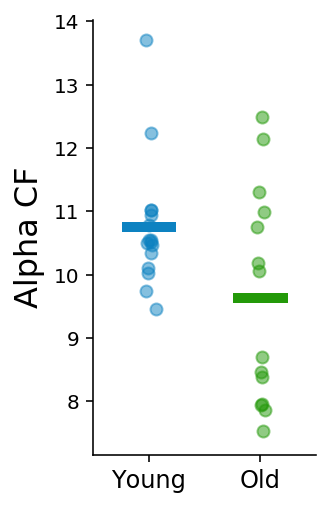

In [28]:
plot_comp_scatter(alphas[:, 0], 'Alpha CF', save_fig=save_fig, save_name='AlphaCF')

### Alpha - Power

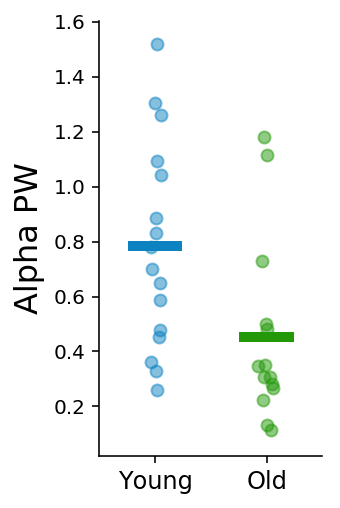

In [29]:
plot_comp_scatter(alphas[:, 1], 'Alpha PW', save_fig=save_fig, save_name='AlphaPW')

### Alpha - Bandwidth

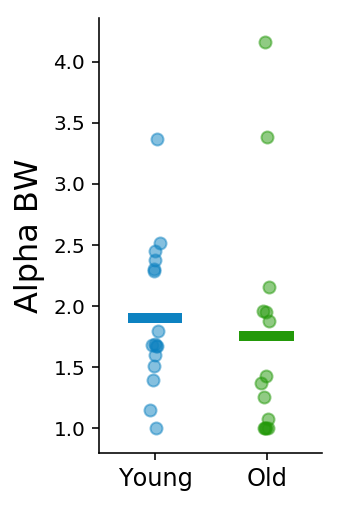

In [30]:
plot_comp_scatter(alphas[:, 2], 'Alpha BW', save_fig=save_fig, save_name='AlphaBW')

### Alpha Oscillations - Individual Variation

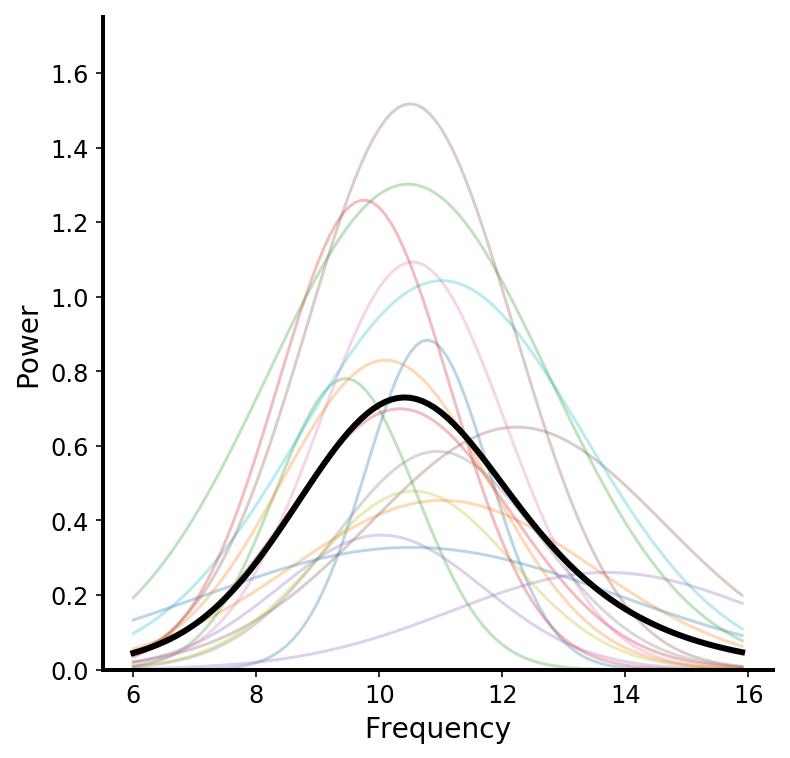

In [31]:
plot_oscillations(alphas[YNG_INDS, :], save_fig=save_fig, save_name='YoungAlphas')

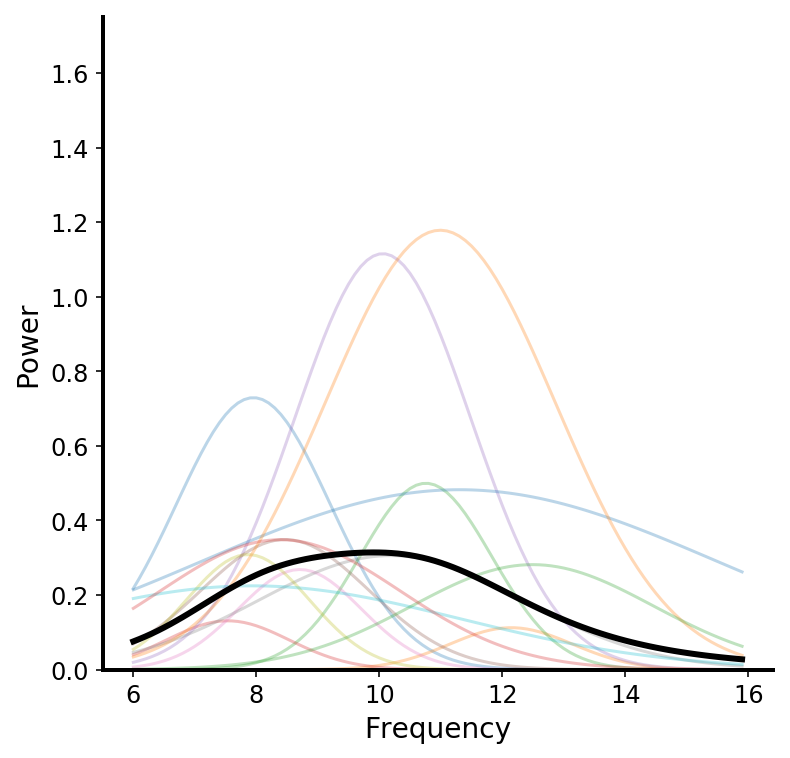

In [32]:
plot_oscillations(alphas[OLD_INDS, :], save_fig=save_fig, save_name='OldAlphas')

### Overlap of Individualized Alpha with Canonical Band



In [33]:
# Calculate overlaps
overlaps = calc_overlaps(alphas)

In [34]:
# Check average (overall) of overlaps, and stats
print('ALL avg overlap:  {:1.4f}'.format(np.mean(np.abs(overlaps))))#, '\n')

print_stat('Diff Overlap:', *ttest_ind(overlaps[YNG_INDS], overlaps[OLD_INDS]))
print_stat('YNG/OLD Means', np.mean(overlaps[YNG_INDS]), np.mean(overlaps[OLD_INDS]))
print_stat('Abs/Std Diff', mean_diff(overlaps[YNG_INDS], overlaps[OLD_INDS]),
                             cohens_d(overlaps[YNG_INDS], overlaps[OLD_INDS]))

ALL avg overlap:  0.7721
Diff Overlap:: 	  2.2457 	 0.0328
YNG/OLD Means: 	  0.8388 	 0.7112
Abs/Std Diff: 	  0.1276 	 0.8245


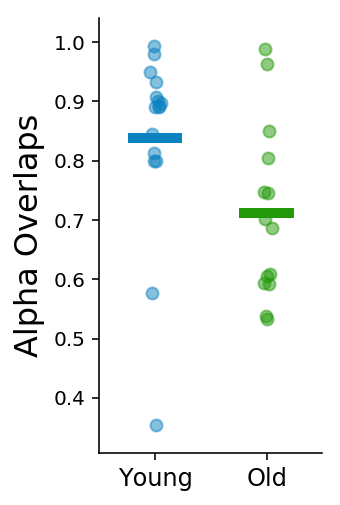

In [35]:
plot_comp_scatter(overlaps, 'Alpha Overlaps', save_fig=save_fig, save_name='AlphaOverlaps')

In [36]:
# Calculate the differences per subject from a 10 Hz center
overlap_diffs = alphas[:, 0] - 10
yng_overlaps = overlap_diffs[YNG_INDS]
old_overlaps = overlap_diffs[OLD_INDS]

In [37]:
print('Directional Differences from 10 Hz Center, by Group')
print('YNG-Diff {: 1.2f}'.format(np.mean(yng_overlaps)))
print('OLD-Diff {: 1.2f}'.format(np.mean(old_overlaps)))
print('\n')
print('Absolute Differences from 10 Hz Center, by Group')
print('YNG-Diff {: 1.2f}'.format(np.mean(np.abs(yng_overlaps))))
print('OLD-Diff {: 1.2f}'.format(np.mean(np.abs(old_overlaps))))

Directional Differences from 10 Hz Center, by Group
YNG-Diff  0.75
OLD-Diff -0.37


Absolute Differences from 10 Hz Center, by Group
YNG-Diff  0.85
OLD-Diff  1.51


#### Plot Overlap

Plot for an example case, using the average deviation from 10 Hz. 

Compare canonical 10 +/- 2, with a gaussian centered with average deviation

Note: in this approach, average deviation shifted below 10 Hz

This is arbitrary - still captures deviations above 10 - could be equivalently calculated that way

In [38]:
# Get the average deviation from center of 10 Hz (across groups)
avg_deviation = np.mean(np.abs(alphas[:, 0] - 10))

In [39]:
# Get average deviation, per group
yng_deviation = np.mean(np.abs(alphas[YNG_INDS, 0] - 10))
old_deviation = np.mean(np.abs(alphas[OLD_INDS, 0] - 10))

In [40]:
# Check the average deviations
print('ALL :\t {:1.4f}'.format(avg_deviation))
print('YNG :\t {:1.4f}'.format(yng_deviation))
print('OLD :\t {:1.4f}'.format(old_deviation))

ALL :	 1.1928
YNG :	 0.8472
OLD :	 1.5058


In [41]:
# Set up values for overalp analysis
vals_avg = (10 - avg_deviation, 10, 2, 2)
r_avg = get_intersect(*vals_avg)
vals_yng = (10 + yng_deviation, 10, 2, 2)
r_yng = get_intersect(*vals_yng)
vals_old = (10 - old_deviation, 10, 2, 2)
r_old = get_intersect(*vals_old)

In [42]:
# Check the average overlaps
print('ALL: \t {:1.4f}'.format(get_overlap(r_avg, *vals_avg)))
print('YNG: \t {:1.4f}'.format(get_overlap(r_yng, *vals_yng)))
print('OLD: \t {:1.4f}'.format(get_overlap(r_old, *vals_old)))

ALL: 	 0.7655
YNG: 	 1.1677
OLD: 	 0.7066


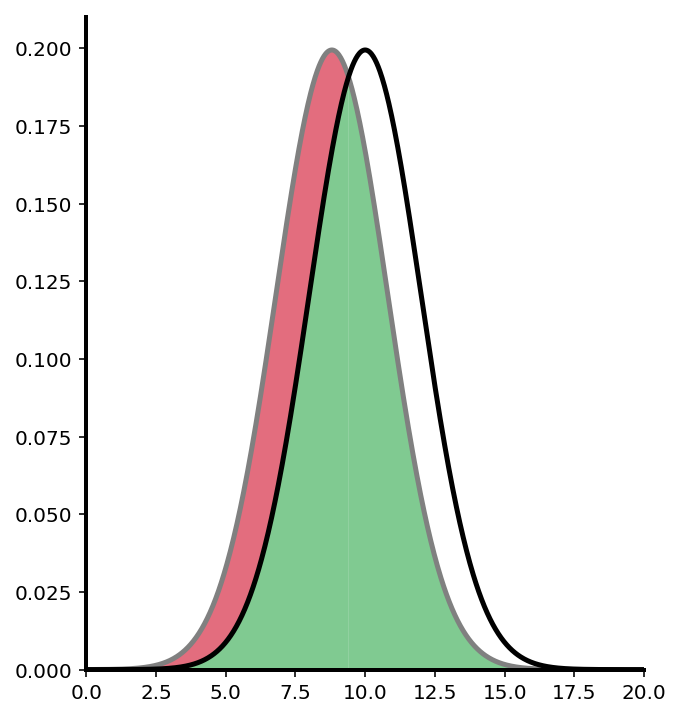

In [43]:
# Plot the overlap of canonical and average shifted alpha: ALL
plot_overlap(*vals_avg, save_fig=save_fig, save_name='CanonicalCompare-Avg')

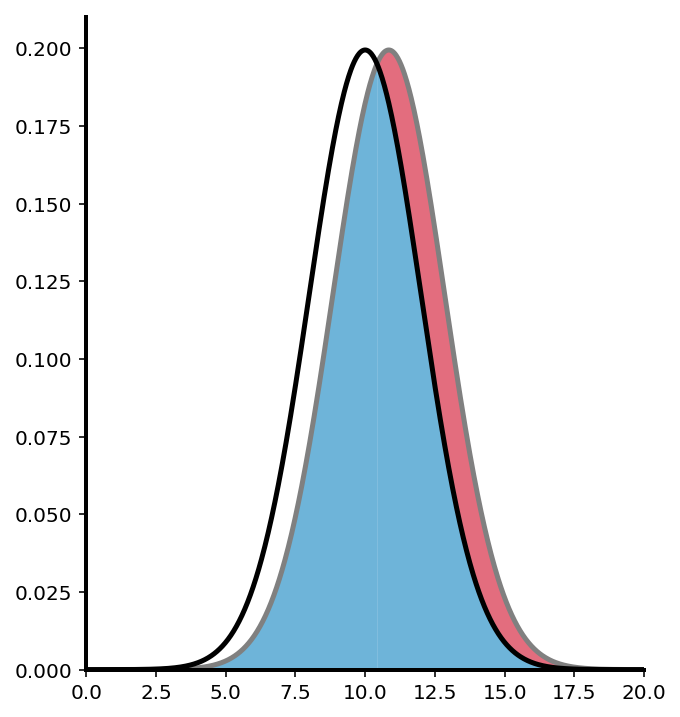

In [44]:
# Plot the overlap of canonical and average shifted alpha: YNG
plot_overlap(*vals_yng, col=YNG_COL, save_fig=save_fig, save_name='CanonicalCompare-Yng')

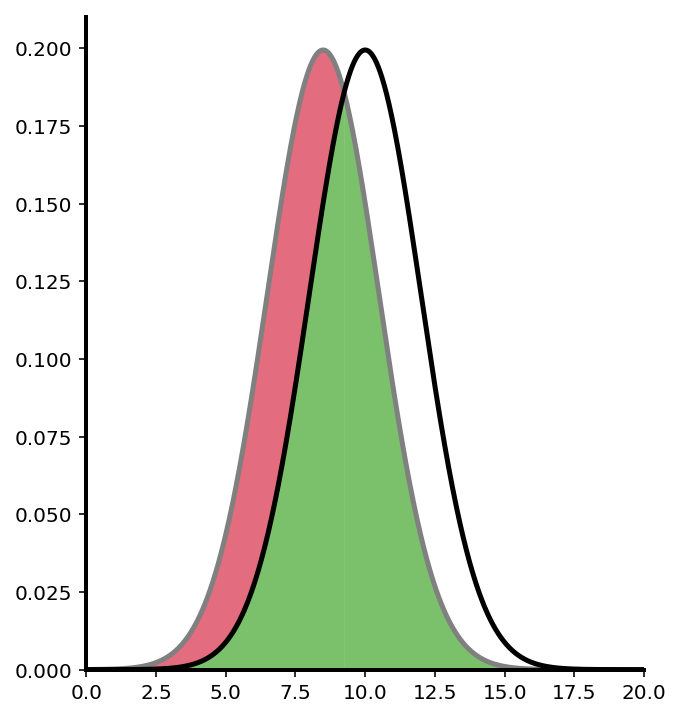

In [45]:
# Plot the overlap of canonical and average shifted alpha: OLD
plot_overlap(*vals_old, col=OLD_COL, save_fig=save_fig, save_name='CanonicalCompare-Old')

### Compare 'Frequency Specific' Differences from Aperiodic

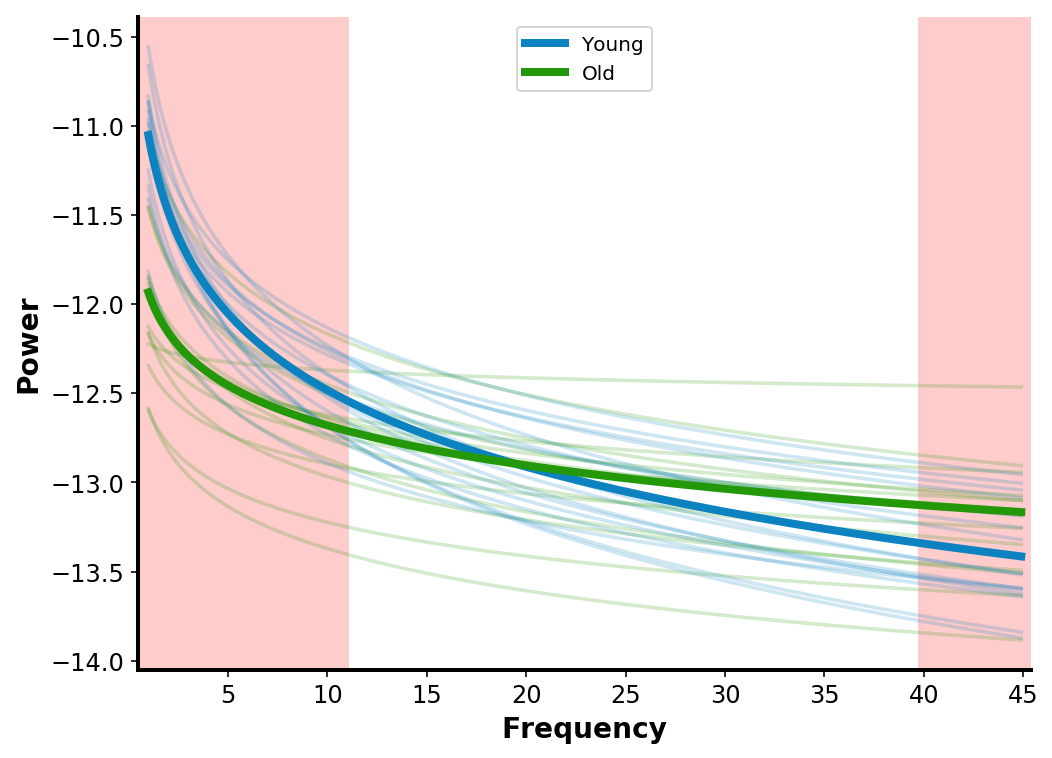

In [46]:
# Plot aperiodics with a the comparison of differences at each frequency
fs, difs, ps = plot_aperiodic(aps, save_fig=save_fig, save_name='Aperiodics', return_vals=True)

In [47]:
# Check frequencies at which p-value switches
fs[np.argwhere(np.diff(np.array(ps) < 0.05))]

array([[10.5],
       [40.1]])

### Compare 'Peaks' from Aperiodic

Question: compare with just exponent, or with exponent & offset?

In [48]:
# Pull out the difference in power, at 10 Hz, arising from BG difference
exp_alphas = []
for ap in aps:
    exp_alphas.append(expo_nk_function(np.array([10]), *ap)[0])
    #exp_alphas.append(expo_nk_function(np.array([10]), 1, ap[1])[0])
    #exp_alphas.append(expo_nk_function(np.array([10]), ap[0], 1)[0])
exp_alphas = np.array(exp_alphas)

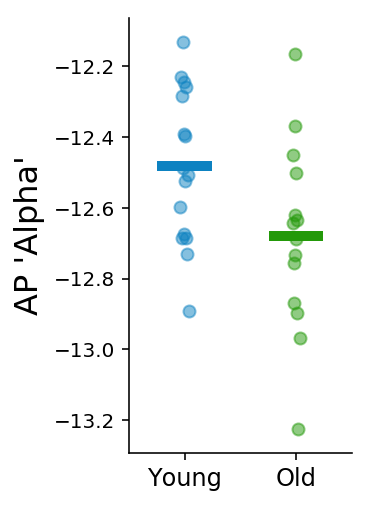

In [49]:
# Compare the 'alpha' difference - coming only from aperiodic differences
plot_comp_scatter(exp_alphas, "AP 'Alpha'", save_fig=save_fig, save_name='APAlpha')

In [50]:
# Statistically test difference in 'AP-Alpha'
print_stat('AP-Al Diff', *ttest_ind(exp_alphas[YNG_INDS], exp_alphas[OLD_INDS]))

AP-Al Diff: 	  2.2358 	 0.0335


#### Compare across all frequencies

Note: Old version of figure. 

In [51]:
# Calculate aperiodic components of power spectra for each subject
freqs = range(2, 50, 2)
model_aps = []
for ap in aps:
    model_aps.append(expo_nk_function(np.array(freqs), *ap))
    #model_aps.append(expo_nk_function(np.array(freqs), 0, ap[1]))
    #model_aps.append(expo_nk_function(np.array(freqs), ap[0], 1))
model_aps = np.array(model_aps)

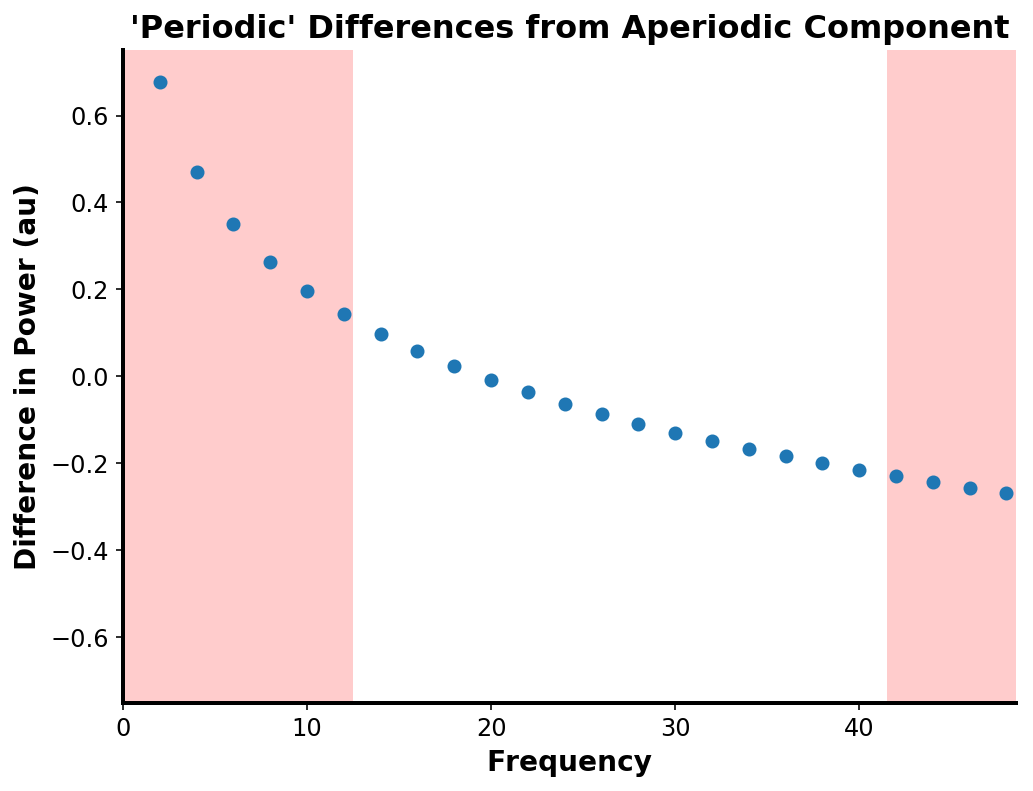

In [52]:
# Calculate average difference per frequency, and plot comparison
avg_diffs, p_vals = calc_ap_comps(freqs, model_aps)
plot_ap_band_diff(freqs, avg_diffs, p_vals)

## Controls - check errors

Check that there isn't a systematic different in model fit error / R^2 that could explain differences

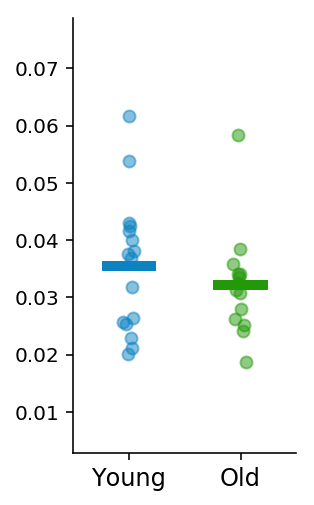

In [53]:
# Compare errors between groups
plot_comp_scatter(errs)

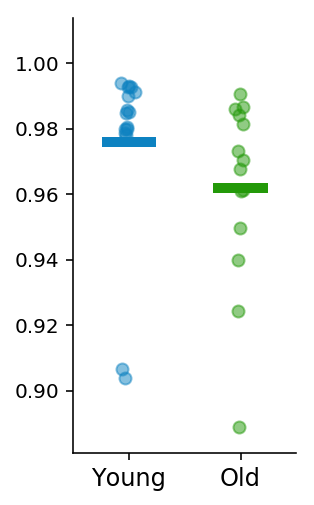

In [54]:
# Compare errors between groups
plot_comp_scatter(r2s)

In [55]:
# Statistically compare errors and R^2 between groups
print_stat('Errors', *ttest_ind(errs[YNG_INDS], errs[OLD_INDS]))
print_stat('R-squared', *ttest_ind(r2s[YNG_INDS], r2s[OLD_INDS]))

Errors: 	  0.8495 	 0.4028
R-squared: 	  1.3772 	 0.1793


In [56]:
# Check the correlation between errors and R^2s
print_stat('Errs & R2s ', *pearsonr(errs, r2s))

Errs & R2s : 	 -0.6201 	 0.0002


## Correlations between FOOOF Features

In [57]:
# Seperate out Oz BG parameters
oz_offs = oz_aps[:, 0]; oz_exps = oz_aps[:, 1]

In [58]:
# Correlation between aperiodic features
print_stat('Cz - OF  &  EX ', *pearsonr(offs, exps))
print_stat('Oz - OF  &  EX ', *pearsonr(oz_offs, oz_exps))

Cz - OF  &  EX : 	  0.8868 	 0.0000
Oz - OF  &  EX : 	  0.8520 	 0.0000


In [59]:
# Correlations between oscillation features
print_stat('Osc - CF  &  PW', *pearsonr(alphas[:, 0], alphas[:, 1]))
print_stat('Osc - CF  &  BW ', *pearsonr(alphas[:, 0], alphas[:, 2]))
print_stat('Osc - PW  &  BW ', *pearsonr(alphas[:, 1], alphas[:, 2]))

Osc - CF  &  PW: 	  0.1657 	 0.3730
Osc - CF  &  BW : 	  0.3299 	 0.0699
Osc - PW  &  BW : 	 -0.0544 	 0.7714


In [60]:
# Correlations between exponent and oscillation features
print_stat('CF  &  EX ', *pearsonr(alphas[:, 0], oz_exps))
print_stat('PW  &  EX ', *pearsonr(alphas[:, 1], oz_exps))
print_stat('BW  &  EX ', *pearsonr(alphas[:, 2], oz_exps))

CF  &  EX : 	  0.3944 	 0.0281
PW  &  EX : 	  0.0915 	 0.6245
BW  &  EX : 	  0.4672 	 0.0081


In [61]:
# Oz alpha with Cz exponent (?)
print_stat('Oz CF  & Cz EX', *pearsonr(alphas[:, 0], exps))
print_stat('Oz PW  & Cz EX', *pearsonr(alphas[:, 1], exps))
print_stat('Oz BW  & Cz EX', *pearsonr(alphas[:, 2], exps))

Oz CF  & Cz EX: 	  0.3338 	 0.0664
Oz PW  & Cz EX: 	  0.3650 	 0.0435
Oz BW  & Cz EX: 	  0.3260 	 0.0735


In [62]:
# Correlation between FOOOF outputs and error
print_stat('Oz CF  &  Err', *pearsonr(errs, alphas[:, 0]))
print_stat('Oz PW  &  Err', *pearsonr(errs, alphas[:, 1]))
print_stat('Oz BW  &  Err', *pearsonr(errs, alphas[:, 2]))
print_stat('Oz EX  &  Err', *pearsonr(errs, oz_exps))

Oz CF  &  Err: 	 -0.2017 	 0.2766
Oz PW  &  Err: 	  0.3339 	 0.0664
Oz BW  &  Err: 	 -0.2608 	 0.1565
Oz EX  &  Err: 	 -0.2105 	 0.2556


In [63]:
# Correlation between FOOOF outputs and r2s
print_stat('Oz CF  &  R^2', *pearsonr(r2s, alphas[:, 0]))
print_stat('Oz PW  &  R^2', *pearsonr(r2s, alphas[:, 1]))
print_stat('Oz BW  &  R^2', *pearsonr(r2s, alphas[:, 2]))
print_stat('Oz EX  &  R^2', *pearsonr(r2s, oz_exps))

Oz CF  &  R^2: 	  0.3917 	 0.0293
Oz PW  &  R^2: 	  0.2822 	 0.1241
Oz BW  &  R^2: 	  0.3919 	 0.0292
Oz EX  &  R^2: 	  0.5332 	 0.0020
